In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MADRONA_MWGPU_KERNEL_CACHE"]="/scratch/ankit/madrona_mjx/build/kernel_cache"
os.environ["MADRONA_BVH_KERNEL_CACHE"]="/scratch/ankit/madrona_mjx/build/bvh_cache"
os.environ["MUJOCO_GL"]="egl"
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [2]:
from myosuite.train.myouser.custom_ppo.networks_vision_multimodal import make_cnn_encoder, make_cnn_decoder
from myosuite.train.utils.wrapper import wrap_curriculum_training
import flax
from brax.training.networks import FeedForwardNetwork
from ArmReach_LLC_UitB import main
from typing import Mapping, Tuple
import jax
import jax.numpy as jnp
from brax.training.types import Params
import matplotlib.pyplot as plt
from flax import linen as nn

MyoSuite:> Registering Myo Envs
MyoSuite:> Registering MyoUser Envs


In [3]:
class TargetPosPredictor(nn.Module):
    c_hid: int
    c_mid: int
    c_out: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x)
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=self.c_mid)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=self.c_out)(x)
        return x


In [4]:
NUM_ENVS = 128

env = main(experiment_id='autoencoder_default', project_id='test_autoencoder', adaptive_increase_success_rate=1.1,
           adaptive_decrease_success_rate=-0.1, init_target_area_width_scale=1.0, get_env_only=True, num_envs=NUM_ENVS, vision_mode='depth')

/scratch/ankit/miniforge3/envs/madmjx/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Overriding reach weight to 1.0
Overriding bonus weight to 8.0
Overriding reach metric coefficient to 10.0
Reach metric coefficient: 10.0
Reward keys and weights: {'reach': 1.0, 'bonus': 8.0, 'neural_effort': 0}
Using vision, so 2.5x timesing dwell threshold to 12.5
Using raytracer
loading BVH kernels from cache
Initialization finished


In [5]:
jit_reset = jax.jit(env.reset)

def get_data(rng_key_id):
    key = jax.random.PRNGKey(rng_key_id)
    state = jit_reset(jax.random.split(key, NUM_ENVS))
    return state.obs['pixels/depth'], state.info['target_pos']

In [6]:
vision_obs, target_pos = get_data(0)

target_pos_predictor = TargetPosPredictor(c_hid=32, c_mid=128, c_out=3)

params = target_pos_predictor.init(jax.random.PRNGKey(0), vision_obs)

out = target_pos_predictor.apply(params, vision_obs)

print(out.shape)

(128, 3)


In [7]:
def mse_loss(pred, target):
    diff = pred - target
    return jnp.mean(diff * diff)

  0%|          | 4/1000 [00:07<23:16,  1.40s/it]  

Step 0, Loss: 0.3705825209617615


 13%|█▎        | 131/1000 [00:07<00:12, 68.78it/s]

Step 100, Loss: 0.002133425325155258


 24%|██▎       | 236/1000 [00:08<00:04, 158.95it/s]

Step 200, Loss: 0.0018013855442404747


 34%|███▍      | 342/1000 [00:08<00:03, 198.04it/s]

Step 300, Loss: 0.0010936326580122113


 43%|████▎     | 427/1000 [00:09<00:02, 206.18it/s]

Step 400, Loss: 0.0010844984790310264


 53%|█████▎    | 532/1000 [00:09<00:02, 208.09it/s]

Step 500, Loss: 0.0006308902520686388


 64%|██████▎   | 637/1000 [00:10<00:01, 208.40it/s]

Step 600, Loss: 0.0007102933595888317


 72%|███████▏  | 723/1000 [00:10<00:01, 209.09it/s]

Step 700, Loss: 0.0004530705919023603


 83%|████████▎ | 828/1000 [00:11<00:00, 208.67it/s]

Step 800, Loss: 0.00034465044154785573


 93%|█████████▎| 933/1000 [00:11<00:00, 208.55it/s]

Step 900, Loss: 0.00029494313639588654


100%|██████████| 1000/1000 [00:12<00:00, 82.37it/s]


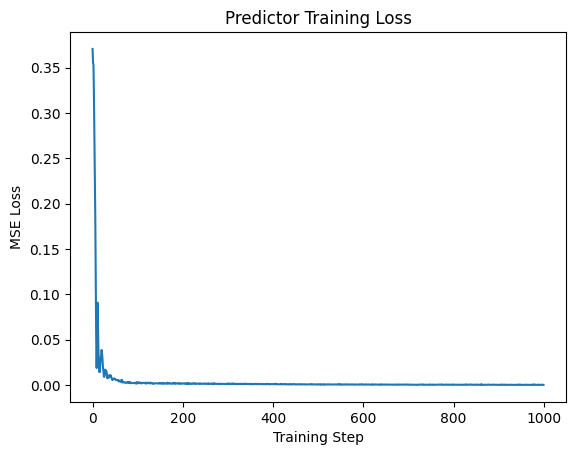

In [14]:
import optax
from flax.training import train_state
import tqdm

# 1. Create optimizer
learning_rate = 3e-4
optimizer = optax.adam(learning_rate)

# 2. Create TrainState
# Using TrainState is a best practice in Flax to keep track of model params, optimizer state etc.
class AutoEncoderTrainState(train_state.TrainState):
    # we can add any other things we want to track during training here
    pass

train_state = AutoEncoderTrainState.create(
    apply_fn=target_pos_predictor.apply,
    params=params,
    tx=optimizer,
)

# 3. Define the training step
@jax.jit
def train_step(state, rng):
    """A single training step."""
    rng, reset_rng = jax.random.split(rng)
    
    # Generate new data for each step
    env_state = jit_reset(jax.random.split(reset_rng, NUM_ENVS))
    images = env_state.obs['pixels/depth']
    targets = env_state.info['target_pos']

    def loss_fn(params):
        preds = state.apply_fn(params, images)
        loss = mse_loss(preds, targets)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    
    state = state.apply_gradients(grads=grads)
    
    return state, loss, rng

# 4. Training loop
num_training_steps = 1000
training_rng = jax.random.PRNGKey(1)

losses = []

for i in tqdm.tqdm(range(num_training_steps)):
    train_state, loss, training_rng = train_step(train_state, jax.random.PRNGKey(i))
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.title("Predictor Training Loss")
plt.show()


In [15]:
# 5. Visualize results
# Get a new batch of images
final_rng, reset_rng = jax.random.split(training_rng)
env_state = jit_reset(jax.random.split(reset_rng, NUM_ENVS))
original_images = env_state.obs['pixels/depth']
targets = env_state.info['target_pos']

# Get predictions
preds = train_state.apply_fn(train_state.params, original_images)

In [21]:
diff = preds - targets

diff_norm = jnp.linalg.norm(diff, axis=1)

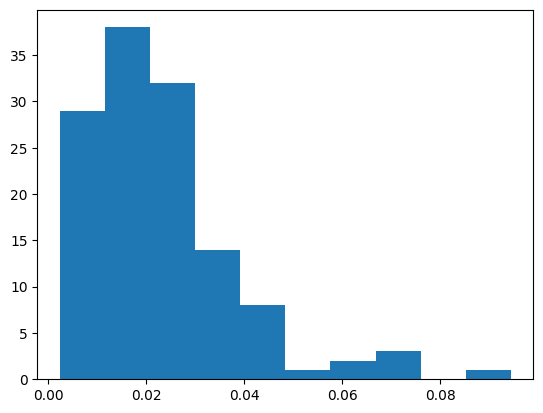

In [23]:
plt.hist(diff_norm)
plt.show()